# Load necessary modules

In [1]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# # import for EM Merger and viz
from keras_retinanet.utils import EmMerger
# from utils import create_folder, root_dir


# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
from tqdm import tqdm_notebook
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.compat.v1.Session(config=config)



# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


SyntaxError: invalid syntax (<ipython-input-4-a1cf261c0a84>, line 1)

# Load RetinaNet model

In [2]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = os.path.join('weights', 'resnet50_csv_01.h5')

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')


# load label to names mapping for visualization purposes
labels_to_names = {0: 'object'}
print(labels_to_names)

AttributeError: module 'tensorflow._api.v2.train' has no attribute 'Optimizer'

# Run detection on example

processing time:  2.7539570331573486
found 32 boxes above threshold
[  0  24 822 868]
[550 704 655 881]
[ 62   1 178 133]
[757 700 822 881]
[676   1 817 143]
[570 473 657 667]
[435 702 542 881]
[ 80 206 172 423]
[165 199 263 420]
[426 207 515 418]
[488 473 575 658]
[603 209 693 420]
[102 471 186 663]
[253 207 345 424]
[176   1 280 135]
[645 476 735 663]
[605  10 684 148]
[328 708 435 881]
[179 468 265 668]
[725 470 816 662]
[347 208 433 423]
[495   1 560 136]
[513 219 606 430]
[688 214 779 422]
[340 470 423 657]
[559  11 646 140]
[428   0 497 136]
[312   0 425 144]
[228 706 329 881]
[533 474 626 661]
[128 708 231 881]
[259 469 343 659]


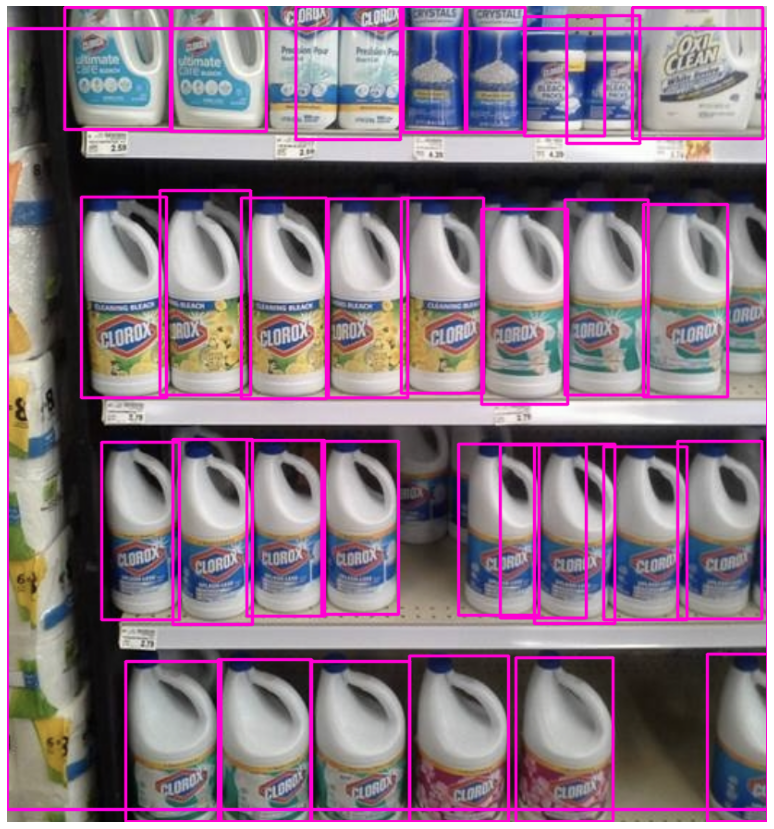

In [23]:

# load image
image_path = "0.png"
image = read_image_bgr(image_path)


# for filtering predictions based on score (objectness/confidence)
threshold = 0.3

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)


# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)


# process image
start = time.time()

boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)
print(f"found {len([x for x in scores[0] if x > threshold])} boxes above threshold")

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < threshold:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    print(b)
    draw_box(draw, b, color=color)
    draw_caption(draw, b, "")
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

array([1023,  457, 1165,  535])

# Load Retinanet + IoU Model

In [99]:
model_path = os.path.join('weights', 'model.h5')
model = models.load_model(model_path, backbone_name='resnet50')

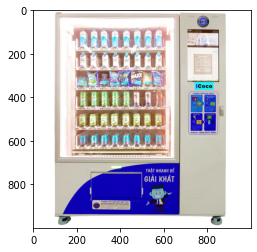

In [133]:

# load image
image_path = "5.jpg"

# load image
image = read_image_bgr(image_path)
plt.imshow(image)
# for filtering predictions based on score (objectness/confidence)
threshold = 0.3

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# Run inference
boxes, hard_scores, labels, soft_scores = model.predict_on_batch(np.expand_dims(image, axis=0))

51


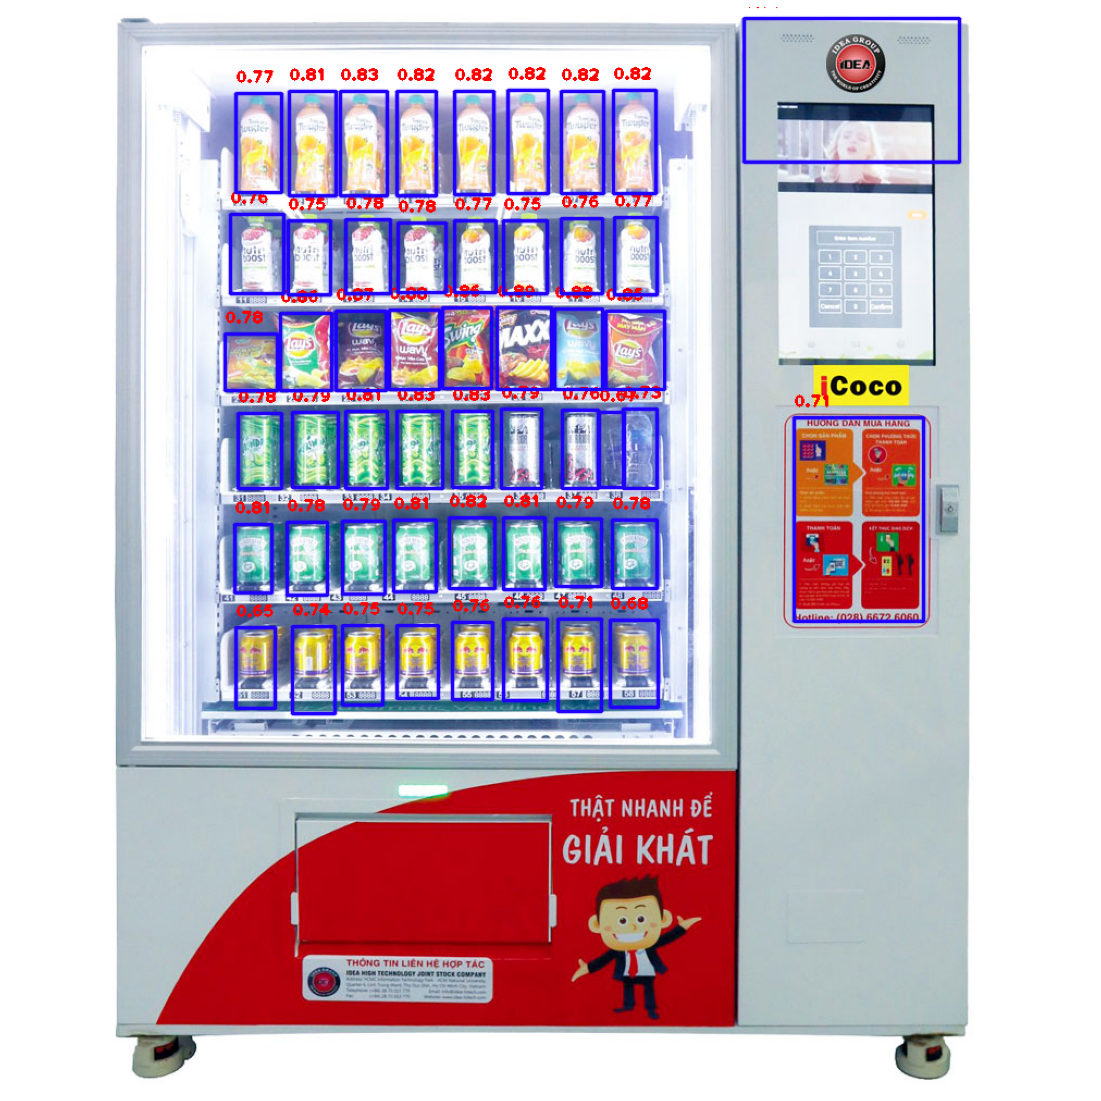

In [134]:
hard_score_rate=.3
max_detections = 9999

soft_scores = np.squeeze(soft_scores, axis=-1)
soft_scores = hard_score_rate * hard_scores + (1 - hard_score_rate) * soft_scores

# correct boxes for image scale
boxes /= scale

# select indices which have a score above the threshold
indices = np.where(hard_scores[0, :] > threshold)[0]

# select those scores
scores = soft_scores[0][indices]
hard_scores = hard_scores[0][indices]

# find the order with which to sort the scores
scores_sort = np.argsort(-scores)[:max_detections]

# select detections
image_boxes = boxes[0, indices[scores_sort], :]
image_scores = scores[scores_sort]
image_hard_scores = hard_scores[scores_sort]
image_labels = labels[0, indices[scores_sort]]
image_detections = np.concatenate(
    [image_boxes, np.expand_dims(image_scores, axis=1), np.expand_dims(image_labels, axis=1)], axis=1)
results = np.concatenate(
    [image_boxes, np.expand_dims(image_scores, axis=1), np.expand_dims(image_hard_scores, axis=1),
     np.expand_dims(image_labels, axis=1)], axis=1)
filtered_data = EmMerger.merge_detections(image_path, results)
filtered_boxes = []
filtered_scores = []
filtered_labels = []

csv_data_lst = []
csv_data_lst.append(['image_id', 'x1', 'y1', 'x2', 'y2', 'confidence', 'hard_score'])

for ind, detection in filtered_data.iterrows():
    box = np.asarray([detection['x1'], detection['y1'], detection['x2'], detection['y2']])
    filtered_boxes.append(box)
    filtered_scores.append(detection['confidence'])
    filtered_labels.append('{0:.2f}'.format(detection['hard_score']))
    row = [image_path, detection['x1'], detection['y1'], detection['x2'], detection['y2'],
           detection['confidence'], detection['hard_score']]
    csv_data_lst.append(row)
 


print(len(filtered_boxes))
      
for box, score, label in zip(filtered_boxes, filtered_scores, filtered_labels):
    # scores are sorted so we can break
    if score < threshold:
        break
        
    color = [31, 0, 255]#label_color(label) ## BUG HERE LABELS ARE FLOATS SO COLOR IS HARDCODED 
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = str(round(score,2))
    draw_caption(draw, b, caption)

plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(draw)
plt.show()    